# Imports

In [1]:
from pyiron_contrib.tinybase.job import GenericTinyJob

/home/poul/pyiron/contrib/pyiron_contrib/__init__.py:9: UserWarning: pyiron module not found, importing Project from pyiron_base
  warnings.warn("pyiron module not found, importing Project from pyiron_base")


In [2]:
from pyiron_contrib.tinybase.executor import ProcessExecutor

In [3]:
from pyiron_contrib.tinybase.murn import MurnaghanTask

In [4]:
from pyiron_contrib.tinybase.ase import AseMDTask, AseMinimizeTask, AseStaticTask

In [5]:
from pyiron_contrib.tinybase.project import ProjectAdapter, InMemoryProject

In [6]:
from ase import Atoms

In [7]:
from ase.build import bulk

In [8]:
from ase.calculators.morse import MorsePotential

In [9]:
from pyiron_base import Project

In [10]:
import logging
logging.getLogger().setLevel(0)

# Create Project and a new Job


In [11]:
pr = ProjectAdapter(Project('tinyjob'))

## MD Job

In [12]:
j = GenericTinyJob(pr, 'md')

In [19]:
j.task_class = AseMDTask

In [20]:
j.input.structure = bulk('Fe', a=1.2, cubic=True).repeat(2)
j.input.calculator = MorsePotential()

In [21]:
j.input.steps = 100
j.input.timestep = 3
j.input.temperature = 600
j.input.output_steps = 20

In [22]:
j.run(how='foreground')

DEBUG:h5py._conv:Creating converter from 5 to 3


In [23]:
j.output.animate_structures()

NGLWidget(max_frame=21)

## Min Job

In [24]:
j = GenericTinyJob(pr, 'min')

In [25]:
j.task_class = AseMinimizeTask

In [26]:
j.input.structure = Atoms(symbols=['Fe', 'Fe'], positions=[[0,0,0], [0,0, .75]], cell=[10,10,10])
j.input.structure.rattle(1e-3)
j.input.calculator = MorsePotential()

In [27]:
j.input.lbfgs(damping=.25)
j.input.max_steps = 100
j.input.output_steps = 10

In [30]:
exe = j.run(how='process')
if exe is not None:
    exe.wait()

       Step     Time          Energy         fmax
LBFGS:    0 17:09:11       11.288146      189.5231
LBFGS:    1 17:09:11        1.168671       43.6957
LBFGS:    2 17:09:11        0.860403       38.6924
LBFGS:    3 17:09:11        0.362400       30.3554
LBFGS:    4 17:09:11        0.004806       24.0865
LBFGS:    5 17:09:11       -0.267437       19.0615
LBFGS:    6 17:09:11       -0.471646       15.0628
LBFGS:    7 17:09:11       -0.623506       11.8810
LBFGS:    8 17:09:11       -0.735237        9.3518
LBFGS:    9 17:09:11       -0.816458        7.3435
LBFGS:   10 17:09:11       -0.874705        5.7512
LBFGS:   11 17:09:11       -0.915849        4.4909
LBFGS:   12 17:09:11       -0.944435        3.4955
LBFGS:   13 17:09:11       -0.963943        2.7113
LBFGS:   14 17:09:11       -0.977006        2.0956
LBFGS:   15 17:09:11       -0.985585        1.6137
LBFGS:   16 17:09:11       -0.991109        1.2382
LBFGS:   17 17:09:11       -0.994598        0.9468
LBFGS:   18 17:09:11       -0.99

In [31]:
j.project.database.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,3,pyiron,murn,3,1,3,/home/poul/pyiron/contrib/notebooks/tinybase/t...,finished,MurnaghanTask
1,4,pyiron,md,1,1,4,/home/poul/pyiron/contrib/notebooks/tinybase/t...,finished,AseMDTask
2,5,pyiron,min,2,1,5,/home/poul/pyiron/contrib/notebooks/tinybase/t...,finished,AseMinimizeTask


In [32]:
j.output.animate_structures()

NGLWidget(max_frame=11)

Escape hatch to old HDF output.

### Loading from job id or name works

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/poul/micromamba/envs/contrib/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/poul/micromamba/envs/contrib/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/poul/micromamba/envs/contrib/lib/python3

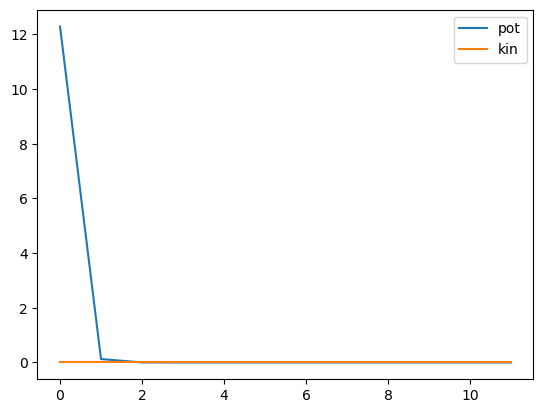

In [33]:
j.project.load(j.id).output.plot_energies()

In [34]:
j.project.load(j.name).output.animate_structures()

NGLWidget(max_frame=11)

## Murnaghan

In [35]:
murn = GenericTinyJob(pr, 'murn')

In [37]:
murn.task_class = MurnaghanTask

In [38]:
murn.input.task = AseStaticTask()
murn.input.task.input.calculator = MorsePotential()

In [39]:
murn.input.structure = bulk("Fe", a=1.2)

In [40]:
murn.input.set_strain_range(.5, 500)

In [41]:
murn.input.child_executor = ProcessExecutor

In [42]:
exe = murn.run()

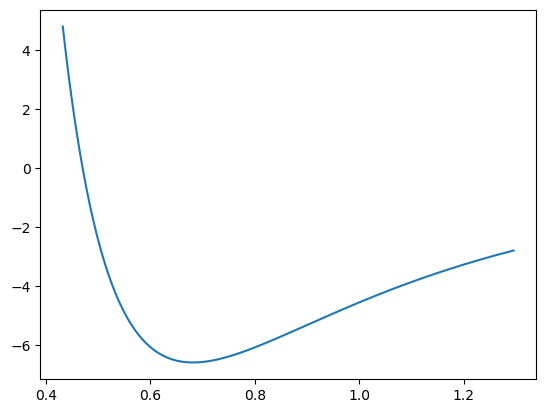

In [43]:
murn.output.plot()

# Pyiron purely in memory

Because the new ProjectInterface completely controls both the storage class and the database a job sees, we can easily swap them without changing anything in `TinyJob` at all.  As a demonstration we can make here a project that persists only for the duration of the process life time.  But it's not hard to imagine a number  of different project type depending on database configuration or storage location (S3, a single HDF5 for all jobs, etc.)

In [35]:
pr = InMemoryProject('/')

In [36]:
pr.job_table()

""


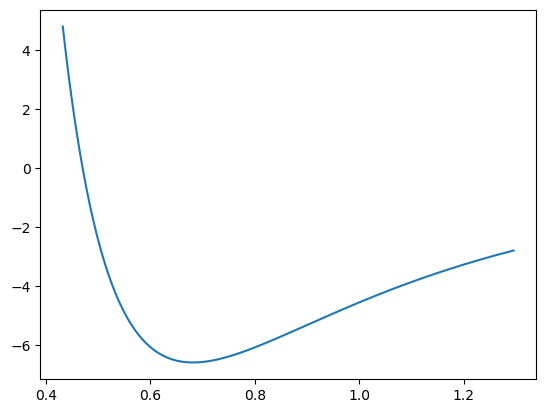

In [37]:
murn = GenericTinyJob(pr, 'murn')
murn.task_class = MurnaghanTask
murn.input.task = AseStaticTask()
murn.input.task.input.calculator = MorsePotential()
murn.input.structure = bulk("Fe", a=1.2)
murn.input.set_strain_range(.5, 500)
murn.input.child_executor = ProcessExecutor
murn.run()
murn.output.plot()

In [38]:
pr.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,1,pyiron,murn,1,1,1,/,finished,MurnaghanTask


In [39]:
j = GenericTinyJob(pr, 'md')
j.task_class = AseMDTask
j.input.structure = bulk('Fe', a=1.2, cubic=True).repeat(2)
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3
j.input.temperature = 600
j.input.output_steps = 20
j.run(how='background')

In [40]:
pr.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,1,pyiron,murn,1,1,1,/,finished,MurnaghanTask
1,2,pyiron,md,2,1,2,/,running,AseMDTask


Subprojects work.

In [41]:
sub = pr.open_location("/foo")
j = GenericTinyJob(sub, 'md')
j.task_class = AseMDTask
j.input.structure = bulk('Fe', a=1.2, cubic=True).repeat(2)
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3
j.input.temperature = 600
j.input.output_steps = 20
j.run(how='process')

In [42]:
pr.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,1,pyiron,murn,1,1,1,/,finished,MurnaghanTask
1,2,pyiron,md,2,1,2,/,running,AseMDTask
2,3,pyiron,md,2,2,3,/foo,running,AseMDTask


# Database Tests

In [43]:
db = j.project.database

In [44]:
db.get_item(1)

DatabaseEntry(name='murn', username='pyiron', project='/', status='finished', jobtype='MurnaghanTask')

In [45]:
eng = db.engine

In [46]:
from sqlalchemy.orm import Session

In [47]:
s = Session(eng)

In [48]:
from pyiron_contrib.tinybase.database import Job, Project as DProject, JobStatus, JobType

In [49]:
s.query(Job.id).where(Job.name == "min", ).all()

[]

In [50]:
s.query(JobStatus.__table__).select_from(Job).where(Job.id == 2, Job.status_id == JobStatus.id).all()

[(2, 'running')]

In [51]:
s.query(JobStatus.__table__).all()

[(1, 'finished'), (2, 'running'), (3, 'running')]

In [52]:
s.query(DProject.__table__).all()

[(1, '/'), (2, '/foo')]

In [53]:
s.query(JobType.__table__).all()

[(1, 'MurnaghanTask'), (2, 'AseMDTask')]